<a href="https://colab.research.google.com/github/SampadSikder/DP-Protocols/blob/main/DiffStats_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Parameter Loading

In [1]:
import argparse
import math
import matplotlib.pyplot as plt

In [2]:
import random
from multiprocessing import Pool
import numpy as np
import xxhash
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass
from typing import Literal, Dict, Any, List
from scipy.special import erfcinv



In [3]:
domain = 0
epsilon = 0.0
n = 0
g = 0
X = []
Y = []
Y_Nattack = []
sample = []
REAL_DIST = []
ESTIMATE_DIST = []
User_Seed = []
User_Seed_Nattack = []
p = 0.0
q = 0.0
Gain = 0
splits = 0
h_ao = 0
global Gain, ESTIMATE_DIST, Y

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
global ESTIMATE_DIST, REAL_DIST, n, p, q, epsilon, domain, User_Seed, User_Seed_Nattack, target_set_size, vswhat, g, splits, h_ao

In [6]:
epsilon = 0.7
splits = 6
h_ao = 1 # for adaptive attack
g = int(round(math.exp(epsilon))) + 1
dataset = 'emoji'
ratio = 0.4
target_set_size = 20

In [7]:
if dataset == 'zipf':
        #n = 100000
        n = 30000
        domain = 1024
if dataset == 'emoji':
        #n = 218477
        n = 70000
        domain = 1496
if dataset == 'fire':
        #n = 723090
        n = 30000
        domain = 296

In [8]:
User_Seed = np.zeros(n)
User_Seed_Nattack = np.zeros(n)
REAL_DIST = np.zeros(domain)
#REAL_DIST = Counter()
ESTIMATE_DIST = np.zeros(domain)

In [9]:
p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
q = 1.0 / (math.exp(epsilon) + g - 1)

print('n: ', n)
print('ratio: ', ratio)
print('target_set_size: ', target_set_size)
print('e: ', epsilon)
print('split: ', splits)
print('h_ao: ', h_ao)

n:  70000
ratio:  0.4
target_set_size:  20
e:  0.7
split:  6
h_ao:  1


## Load Dataset

In [24]:
def generate_zipf_dist():
  global REAL_DIST, domain, sample, X
  X = np.load('/content/drive/MyDrive/Purdue Work/Datasets/zipf.npy')
  for i in range(n):
    REAL_DIST[X[i]] += 1



In [25]:
def generate_emoji_dist():
  global X
  data = np.load('/content/drive/MyDrive/Purdue Work/Datasets/emoji.npy')
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [26]:
def generate_fire_dist():
  global X
  values = pd.read_csv("/content/drive/MyDrive/Purdue Work/Datasets/fire.csv")["Unit_ID"]
  #print(np.array(values))
  lf = LabelEncoder().fit(values)
  data = lf.transform(values)
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [27]:
if dataset == 'zipf':
    generate_zipf_dist()
if dataset == 'emoji':
    generate_emoji_dist()
if dataset == 'fire':
    generate_fire_dist()

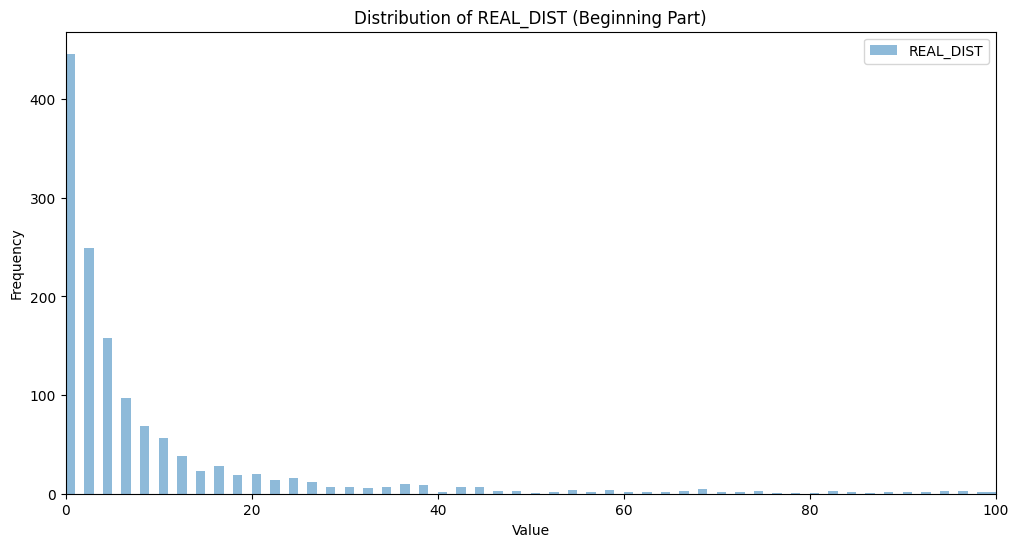

In [28]:
plt.figure(figsize=(12, 6))
plt.hist(REAL_DIST, bins=range(101), alpha=0.5, label='REAL_DIST')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of REAL_DIST (Beginning Part)')
plt.legend()
plt.xlim(0, 100)
plt.show()

## Protocols

In [20]:
from tqdm import tqdm
import random
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
from functools import partial
from multiprocessing import Pool
import math
import scipy.stats as stats
from scipy.stats import binom, chisquare


In [21]:
# APA Attack
def construct_omega(e, d, perturb_method):
    p_binomial = None
    if perturb_method == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(e) + 1)
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / g
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_binomial = 1 / 2
        p = q = 1 / 2
        expected_ones = d * p_binomial
    k_values = [i for i in range(d)]
    theoretical_pdf = binom.pmf(k_values, d, p_binomial)
    theoretical_pdf /= theoretical_pdf.sum()
    return theoretical_pdf

In [22]:
# Example of theoretical pdf from construct_omega
example_pdf = construct_omega(epsilon, domain, 'OLH_User')

print(f'Example of theoretical PDF from construct_omega (first 10 values):')
print(example_pdf[:10])
print(f'Length of the PDF: {len(example_pdf)}')

Example of theoretical PDF from construct_omega (first 10 values):
[2.86931034e-264 2.14733137e-261 8.02971659e-259 2.00041228e-256
 3.73516060e-254 5.57568269e-252 6.93129518e-250 7.38061539e-248
 6.87206466e-246 5.68378460e-244]
Length of the PDF: 1496


In [23]:
def perturb_ideal(target_set = None, ratio = 0, e = 0):
    global Y, Gain, User_Seed
    Y = np.zeros(n)
    #random.shuffle(X)
    for i in range(n):
        if i < n * (1 - ratio):
            v = X[i]
            # intdigest -> get integer value from xxhash(Output of xxhash is a hash item)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()

            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
        else:
            projection_total = len(target_set)
            max_seed = i
            v = random.choice(target_set)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()
            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
    return User_Seed

# Estimates

## Default Estimates

In [32]:
def z_bonferroni(delta_over_d: float) -> float:
    return float((2.0 ** 0.5) * erfcinv(2.0 * delta_over_d))

In [33]:
Mechanism = Literal["OUE", "OLH", "HST_User", "HST_Server"]

def construct_omega(e: float, d: int, perturb_method: str) -> np.ndarray:
    if perturb_method == 'OUE':
        p = 1/2
        q = 1/(math.exp(e) + 1)
        p_bin = (1/d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server', 'OLH'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / (math.exp(e) + g - 1)
        p_bin = (1/d) * (p + (d - 1) * q)
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_bin = 1/2
    else:
        raise ValueError("Unknown perturb_method")
    k = np.arange(d)
    pdf = binom.pmf(k, d, p_bin)
    pdf /= pdf.sum()
    return pdf

def _oq_params_oue(epsilon: float):
    p = 0.5
    q = 1 / (math.exp(epsilon) + 1)
    return p, q

def _olh_params(epsilon: float, n: int):
    g = int(round(math.exp(epsilon))) + 1
    denom = math.exp(epsilon) + g - 1
    p = math.exp(epsilon) / denom
    q = 1.0 / denom
    denom_pg = (p * g - 1.0)
    if abs(denom_pg) < 1e-12:
        a = float('inf')
        b_n = float('inf')
    else:
        a = g / denom_pg
        b_n = n / denom_pg
    return g, p, q, a, b_n

In [34]:
def build_normal_lists_from_mechanism_stochastic(
    epsilon: float, d: int, n: int, mechanism: str = "OUE", seed: int = 0
):
    rng = np.random.default_rng(seed)

    if mechanism == "OUE":
        omega = construct_omega(epsilon, d, 'OUE')
        p, q = 0.5, 1.0 / (math.exp(epsilon) + 1.0)

    elif mechanism == "OLH":
        omega = construct_omega(epsilon, d, 'OLH')
        g, p_olh, q_olh, a, b_n = _olh_params(epsilon, n)

    elif mechanism in ("HST_User", "HST_Server"):
        omega = construct_omega(epsilon, d, mechanism)

    else:
        raise ValueError("mechanism must be 'OUE', 'OLH', 'HST_User', or 'HST_Server'.")

    k_values = np.arange(d)
    K = rng.choice(k_values, size=n, p=omega)

    support = np.zeros((n, d), dtype=int)
    for i, k in enumerate(K):
        if k > 0:
            idx = rng.choice(d, size=min(k, d), replace=False)
            support[i, idx] = 1

    one_list = support.sum(axis=1)
    obs_counts = support.sum(axis=0).astype(float)

    if mechanism == "OUE":
        normal_ESTIMATE_DIST = (obs_counts - n * q) / max(p - q, 1e-12)
    elif mechanism == "OLH":
        normal_ESTIMATE_DIST = a * obs_counts - b_n
    else:
        normal_ESTIMATE_DIST = obs_counts

    normal_ESTIMATE_Input = None
    return support, one_list, normal_ESTIMATE_DIST, normal_ESTIMATE_Input

## OLH

### Attacked OLH

In [35]:
num_samples = 1000000


In [36]:
def uniform_sampling_best_vector(target_set, g, d, m, num_samples):
    best_vector = None
    closest_ones_diff = float('inf')
    max_target_count = 0
    best_score = -float('inf')
    current_target = None
    current_diff = None

    for _ in range(num_samples):
        # Generate uniform samples for binary vectors (0 or 1)
        vector = np.random.binomial(1, 1 / g, size=d)

        # Count the number of 1's in the vector
        ones_count = np.sum(vector)
        ones_diff = abs(ones_count - m)  # Difference between current 1's count and target m

        # Count how many target items map to positions with 1's in the vector
        target_count = sum(1 for item in target_set if vector[item % d] == 1)

        # Calculate the score: target_count - ones_diff
        score = target_count - ones_diff

        # Update the best vector if the score is better
        if score > best_score:
            best_score = score
            best_vector = vector
            current_target = target_count
            current_diff = ones_diff

    return best_vector, current_target, current_diff

In [37]:
def calculate_prob_according_sample_size(num_samples, d, g, h, target_set, splits):

    splits_list = random.sample(list(target_set), splits)
    target_set = splits_list
    user_vectors = []
    p = 1 / g

    mu = d * p
    sigma = np.sqrt(d * p * (1 - p))

    lower_bound = max(0, mu - h)
    upper_bound = min(d, mu + h)

    binom_dist = stats.binom(d, p)
    ratio = (binom_dist.cdf(upper_bound) - binom_dist.cdf(lower_bound - 1))
    ratio = ratio / (2 * h + 1)
    # ratio = 1

    N_effective = num_samples * ratio
    print('N_effective: ', N_effective)

    K_min = 1
    K_max = len(target_set)
    for K in range(K_max, K_min - 1, -1):
        prob = (p) ** K * N_effective
        if prob < 1:
            K_max = K
        else:
            break
    K_min = max(K_max, 1)

    K_values = np.arange(K_min, len(target_set) + 1)
    K_probs = []
    for K in K_values:
        prob = (p) ** K * N_effective
        K_probs.append(prob)
    K_probs = np.array(K_probs)

    K_probs = K_probs / np.sum(K_probs)

    return K_values, K_probs

In [38]:
def process_attacker(i, n, ratio, target_set, g, domain, splits, h_ao, e, K_values, K_probs):
    # Seed the random number generator uniquely for each process
    k = np.random.choice(K_values, p=K_probs)
    random.seed()
    averge_project_hash = int(domain / g)
    if splits < averge_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = averge_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        #h_ao = 0
        if h_ao == 0:
          num_map_AO = random.randint(num_map - int(h_ao), num_map + int(h_ao))
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        else:
          omega_probs = construct_omega(e, domain, 'OLH_User')
          num_map_AO = np.random.choice(range(domain), p=omega_probs)
        non_target_ones = num_map_AO - k
        # Each attacker finds their optimal hash function
        '''best_vector, target_map, diff  = uniform_sampling_best_vector(
            splits_list, g, domain, num_map_AO, num_samples)'''
        target_indices = np.random.choice(list(splits_list), size=k, replace=False)
        non_target_indices = list(set(range(domain)) - set(splits_list))
        non_target_selected = np.random.choice(non_target_indices, size=non_target_ones, replace=False)
        vector = np.zeros(domain, dtype=int)
        vector[target_indices] = 1
        vector[non_target_selected] = 1
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    #print(f'attacker:{i}, target_map:{k}, diff:{num_map_AO - sum(vector)}, h_ao:{h_ao}, splits:{splits}')
    return index, vector

In [39]:
def process_user_seeds(i, User_Seed_noattack, Y_Nattack, domain, g):
    print("Processing index" + str(i))
    local_estimate = np.zeros(domain)
    user_seed = User_Seed_noattack[i]
    for v in range(domain):
        if Y_Nattack[i] == (xxhash.xxh3_64(str(v), seed=int(user_seed)).intdigest() % g):
            local_estimate[v] += 1
    # Apply the correction factor
    local_estimate = local_estimate
    return local_estimate

In [40]:
def find_hash_function(seed_list, target_set, domain_eliminate, g, num_map_AO):
    # log the max projection number
    best_score = -np.inf
    # log the best projection seed
    best_seed = -1
    # log the target mapped
    best_target_mapped = None
    # log the best hash value
    best_hash_value = None
    # log the min gap
    best_gap = None
    for seed in seed_list:
        hash_projection_list = np.zeros(g)
        hash_other_projection_list = np.zeros(g)
        hash_result = None
        for item in target_set:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_projection_list[hash_result] += 1
        for item in domain_eliminate:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_other_projection_list[hash_result] += 1
        score = hash_projection_list - np.abs(num_map_AO - hash_projection_list - hash_other_projection_list)
        current_best_score = np.max(score)
        max_indices = np.where(score == current_best_score)[0]
        current_max_target_mapped = hash_projection_list[max_indices]
        current_untarget_mapped = hash_other_projection_list[max_indices]
        current_hash_value = max_indices
        current_gap = np.abs(num_map_AO - current_max_target_mapped - current_untarget_mapped)
        if current_best_score > best_score:
            best_seed = seed
            best_score = current_best_score
            best_hash_value = current_hash_value
            best_gap = current_gap
            best_target_mapped = current_max_target_mapped
    if best_seed == -1:
        return -1, 0.0, None
    return best_seed, best_gap, best_target_mapped, best_hash_value


In [41]:
def process_attacker_User(i, n, ratio, target_set, g, domain, splits, e, h_ao):
    average_project_hash = int(domain / g)
    vector = np.zeros(domain, dtype=int)
    if splits < average_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = average_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        num_map_AO = random.randint(num_map - h_ao, num_map + h_ao)
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        #num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        seed_list = random.sample(range(1, 10000000), num_samples)
        best_seed, best_gap, current_max_target_mapped, best_hash_value = find_hash_function(seed_list, splits_list,
                                                                                             remaining_set, g,
                                                                                             num_map_AO)
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    for v in range(domain):
        hashed_value = xxhash.xxh3_64(str(v), seed=int(best_seed)).intdigest() % g
        if hashed_value == best_hash_value:
            vector[v] = 1
   # print(f'attacker:{i}, target_map:{current_max_target_mapped}, diff:{best_gap}, h_ao:{h_ao}, splits:{splits}')
    return index, vector


In [42]:

def build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, e, h_ao=0, processor=100):

    K_values, K_probs = calculate_prob_according_sample_size(num_samples, domain, g, h_ao, target_set, splits)

    # Prepare the partial function with fixed arguments for multiprocessing
    process_attacker_partial = partial(
        #process_attacker_User,
        # Simulate 1,000,000 hash samples, fast version
        process_attacker,
        n=n,
        ratio=ratio,
        target_set=target_set,
        g=g,
        domain=domain,
        splits=splits,
        h_ao= 10*h_ao,
        e=e,
        K_values = K_values,
        K_probs = K_probs
    )

    # Calculate the number of attackers
    num_attackers = int(round(n * ratio))

    # Parallel execution of process_attacker using multiprocessing
    with Pool(processes=processor) as pool:
        # Use imap to process in parallel and tqdm for progress bar
        results = list(tqdm(
            pool.imap(process_attacker_partial, range(num_attackers)),
            total=num_attackers,
            desc='Finding optimal seeds'
        ))

    vector_matrix = np.zeros((num_attackers, domain))
    # Update User_Seed with the results from all attackers
    for i, (index, best_vector) in enumerate(results):
        vector_matrix[i, :] = best_vector

    # Create a partial function with fixed arguments for processing user seeds
    process_partial = partial(
        process_user_seeds,
        User_Seed_noattack=User_Seed,
        Y_Nattack=Y,
        domain=domain,
        g=g
    )

    # Process user seeds across multiple processes
    with Pool(processes=processor) as pool:
        estimates = pool.map(process_partial, range(n - num_attackers))
    # input attack's estimate
    '''with Pool(processes=processor) as pool:
        estimates_input = pool.map(process_partial, range(int(n)))'''

    # Combine the results from all processes
    estimates = np.array(estimates)
    # estimates_input = np.array(estimates_input)
    # estimates_input = estimates_input.reshape(int(n), domain)
    estimates = np.vstack((estimates, vector_matrix))
    estimates = estimates.reshape(int(n), domain)
    Results_support = estimates
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = np.sum(Results_support, axis=0)
    # Estimations_input = np.sum(estimates_input, axis=0)
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations = a * Estimations - b
    # Estimations_input = a * Estimations_input - b
    Estimations_input = None
    return Results_support, Results_support_one_list, Estimations, Estimations_input

### Normal OLH

In [70]:
def perturb_normal_olh(X, g, p, q):

    Y_normal = np.zeros(len(X))
    for i, v in enumerate(X):
        # Generate hash value
        x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
        y = x
        p_sample = np.random.random_sample()

        # Apply perturbation
        if p_sample <= p:

            # perturb
            y = np.random.randint(0, g)
        Y_normal[i] = y
    return Y_normal

In [71]:
def build_support_list_normal_olh(Y_normal, n, domain, g, p):
    Results_support_normal = np.zeros((n, domain))
    Estimations_normal_raw = np.zeros(domain)

    for i in range(n):
        user_seed = i  # Use the same seed as in perturbation
        for v in range(domain):
            hashed_value = (xxhash.xxh3_64(str(v), seed=user_seed).intdigest() % g)
            if Y_normal[i] == hashed_value:
                Results_support_normal[i, v] += 1
                Estimations_normal_raw[v] += 1

    Results_support_one_list_normal = np.sum(Results_support_normal, axis=1)

    # Apply the OLH correction factor
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations_normal = a * Estimations_normal_raw - b

    return Results_support_normal, Results_support_one_list_normal, Estimations_normal

## OUE

### Normal OUE

In [65]:
def perturb_normal_oue_process(args):
    start, end, domain, q_OUE, X = args
    local_user_data = np.zeros((end - start, domain), dtype=int)

    for i in tqdm(range(start, end)):
        v = X[i]
        random_flip = np.random.rand(domain) < q_OUE
        local_user_data[i - start, :] = random_flip
        local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
    return local_user_data

In [66]:
def perturb_normal_OUE_multi(X, domain, epsilon, num_processes=1):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5

    # Split the task into chunks for each process
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, domain, q_OUE, X) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_normal_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    return user_data

### Attacked OUE

In [67]:
def build_support_list_1_OUE(estimates, n, epsilon):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE
    Results_support = np.array(estimates)
    Estimations = np.sum(Results_support, axis=0)
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = [(i - n * q_OUE) / (p - q_OUE) for i in Estimations]
    Estimations_input = None

    return Results_support, Results_support_one_list, Estimations, Estimations_input


In [68]:
def perturb_oue_process(args):
    start, end, n, domain, q_OUE, ratio, target_set, X, h_ao, splits, average_1_num_list = args
    local_user_data = np.zeros((end - start, domain), dtype=int)
    h_ao *= 10

    for i in tqdm(range(start, end)):
        v = X[i]
        if i < n * (1 - ratio):
            # benign users
            random_flip = np.random.rand(domain) < q_OUE
            local_user_data[i - start, :] = random_flip
            local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
        else:
            # fake users
            if splits < average_1_num_list[i]:
                splits_list = random.sample(list(target_set), splits)
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
            else:
                splits_list = random.sample(list(target_set), average_1_num_list[i])
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
    return local_user_data

In [69]:
def perturb_OUE_multi(target_set = None, ratio = 0, h_ao = 0, split = 0, num_processes=1):
    global p, q
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE
    #theoretical_pdf = construct_omega(epsilon, domain, 'OUE')
    #average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n
    # theoretical APA use the below code to replace the average_1_num_list and set h_ao = 0
    omega_probs = construct_omega(epsilon, domain, 'OUE')
    if h_ao == 1:
        average_1_num_list = np.random.choice([i for i in range(domain)], size=n, p=omega_probs)
    else:
        # When h_ao is not 1, ensure average_1_num_list is an array of size n
        average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n

    # Split the task into chunks for each process
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, n, domain, q_OUE, ratio, target_set, X, h_ao, split, average_1_num_list) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    #Estimations = np.sum(user_data, axis=0)
    return user_data

## Attacked List of 1s

In [46]:
# Define the protocol (either 'OUE' or 'OLH')
protocol = 'OUE' # Change to 'OUE' to run OUE protocol

In [47]:
target_set = random.sample(range(0, domain), target_set_size)


In [48]:
f_T = sum(REAL_DIST[element] for element in target_set) / sum(REAL_DIST)

Gain = (Gain - n * ratio * (f_T * (p - 1/g) + target_set_size * 1/g)) / (n * (p - 1/g))
print('Gain: ', Gain)

Gain:  -15.839309220756418


In [49]:

User_Seed = perturb_ideal(target_set, ratio, epsilon)

In [50]:
# one_list is per user support, EST_DIST is per domain support and support list is per user 1s list
if protocol == "OLH":
  support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2)
elif protocol == "OUE":
   ESTIMATE_DIST_Matrix = perturb_OUE_multi(target_set, ratio, h_ao, splits)
   perturb_method = 'OUE'
   support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OUE(
        ESTIMATE_DIST_Matrix, n, epsilon)

100%|██████████| 70000/70000 [00:15<00:00, 4652.55it/s]


## Ideal List of 1s

In [62]:
if protocol == "OUE":
    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism="OUE", seed=42)

elif protocol == "OLH":
    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism="OLH", seed=42)

else:
    raise ValueError("protocol must be 'OUE' or 'OLH'")

## Normal List

In [72]:
# Define the protocol (either 'OUE' or 'OLH')
protocol = 'OLH' # Change to 'OUE' to run OUE protocol

if protocol == 'OLH':
    print("Running OLH protocol...")
    # Normal OLH
    Y_normal = perturb_normal_olh(X, g, p, q)
    no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
    no_attack_ESTIMATE_Input = None


elif protocol == 'OUE':
    print("Running OUE protocol...")
    # Normal OUE
    Y_normal = perturb_normal_OUE_multi(X, domain, epsilon, num_processes=2)
    no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST, _ = build_support_list_1_OUE(Y_normal, n, epsilon)

else:
    print("Invalid protocol specified. Please choose 'OLH' or 'OUE'.")

Running OLH protocol...


In [ ]:
#Y_normal = perturb_normal_olh(X, g, p, q)
#no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
#no_attack_ESTIMATE_Input = None

## Comparison

In [53]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

In [54]:
def calculate_distribution_differences(attack_dist, normal_dist, attack_one_list, normal_one_list):
    """
    Calculate various statistical measures to quantify differences between
    attacked and normal distributions/one_lists
    """

    # Ensure arrays are numpy arrays
    attack_dist = np.array(attack_dist)
    normal_dist = np.array(normal_dist)
    attack_one_list = np.array(attack_one_list)
    normal_one_list = np.array(normal_one_list)

    differences = {}

    # 1. Jensen-Shannon Divergence (symmetric KL divergence)
    # Ensure non-negativity and normalize for probability distributions
    attack_prob = np.maximum(attack_dist, 0)
    normal_prob = np.maximum(normal_dist, 0)

    attack_prob = attack_prob / np.sum(attack_prob) if np.sum(attack_prob) > 0 else attack_prob
    normal_prob = normal_prob / np.sum(normal_prob) if np.sum(normal_prob) > 0 else normal_prob

    epsilon = 1e-10
    attack_prob = attack_prob + epsilon
    normal_prob = normal_prob + epsilon
    attack_prob = attack_prob / np.sum(attack_prob)
    normal_prob = normal_prob / np.sum(normal_prob)

    js_divergence = jensenshannon(attack_prob, normal_prob)
    differences['jensen_shannon_divergence'] = js_divergence

    # 2. Kullback-Leibler Divergence (directional)
    kl_divergence = stats.entropy(attack_prob, normal_prob)
    differences['kl_divergence'] = kl_divergence

    # 3. Wasserstein Distance (Earth Mover's Distance)
    # Use the non-negative probabilities for Wasserstein distance
    wasserstein_dist = wasserstein_distance(range(len(attack_dist)), range(len(normal_dist)),
                                          attack_prob, normal_prob)
    differences['wasserstein_distance'] = wasserstein_dist

    # 4. Kolmogorov-Smirnov Test
    # First convert distributions to samples
    # Need to handle potential non-integer counts due to estimation.
    # Rounding to nearest integer or sampling based on probability could be options.
    # For simplicity here, we'll skip KS test on distributions with negative estimates.
    # A more robust approach would involve a different test or distribution transformation.
    attack_samples = np.repeat(range(len(attack_dist)), np.maximum(attack_dist, 0).astype(int))
    normal_samples = np.repeat(range(len(normal_dist)), np.maximum(normal_dist, 0).astype(int))


    if len(attack_samples) > 0 and len(normal_samples) > 0:
        # KS test requires non-negative counts. Using rounded non-negative counts.
        ks_stat, ks_pvalue = ks_2samp(attack_samples, normal_samples)
        differences['ks_statistic'] = ks_stat
        differences['ks_pvalue'] = ks_pvalue
    else:
        differences['ks_statistic'] = np.nan
        differences['ks_pvalue'] = np.nan


    # 5. Chi-square test
    if len(attack_dist) == len(normal_dist):
        # Combine distributions for chi-square test
        # Chi-square test requires non-negative observed and expected frequencies
        observed = np.maximum(attack_dist, 0)
        expected = np.maximum(normal_dist, 0)
        # Avoid division by zero
        expected = np.where(expected == 0, 1e-10, expected) # Use a small epsilon for expected=0
        chi2_stat = np.sum((observed - expected)**2 / expected)
        differences['chi_square_statistic'] = chi2_stat
    else:
        differences['chi_square_statistic'] = np.nan

    # 6. Mean Squared Error between distributions
    if len(attack_dist) == len(normal_dist):
        mse_dist = mean_squared_error(normal_dist, attack_dist) # MSE can handle negative values
        differences['distribution_mse'] = mse_dist
    else:
        differences['distribution_mse'] = np.nan

    # 7. Total Variation Distance
    tv_distance = 0.5 * np.sum(np.abs(attack_prob - normal_prob))
    differences['total_variation_distance'] = tv_distance


    # 8. Statistical moments comparison
    differences['mean_difference'] = np.mean(attack_one_list) - np.mean(normal_one_list)
    differences['std_difference'] = np.std(attack_one_list) - np.std(normal_one_list)
    differences['skewness_difference'] = stats.skew(attack_one_list) - stats.skew(normal_one_list)
    differences['kurtosis_difference'] = stats.kurtosis(attack_one_list) - stats.kurtosis(normal_one_list)

    # 9. Two-sample t-test
    t_stat, t_pvalue = stats.ttest_ind(attack_one_list, normal_one_list)
    differences['t_test_statistic'] = t_stat
    differences['t_test_pvalue'] = t_pvalue

    # 10. Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = stats.mannwhitneyu(attack_one_list, normal_one_list, alternative='two-sided')
    differences['mannwhitney_statistic'] = u_stat
    differences['mannwhitney_pvalue'] = u_pvalue

    # 11. Kolmogorov-Smirnov test for one_lists
    ks_one_stat, ks_one_pvalue = ks_2samp(attack_one_list, normal_one_list)
    differences['ks_one_list_statistic'] = ks_one_stat
    differences['ks_one_list_pvalue'] = ks_one_pvalue

    # 15. Range and IQR differences
    attack_range = np.ptp(attack_one_list)  # peak-to-peak (range)
    normal_range = np.ptp(normal_one_list)
    differences['range_difference'] = attack_range - normal_range

    attack_iqr = np.percentile(attack_one_list, 75) - np.percentile(attack_one_list, 25)
    normal_iqr = np.percentile(normal_one_list, 75) - np.percentile(normal_one_list, 25)
    differences['iqr_difference'] = attack_iqr - normal_iqr


    return differences

In [55]:
def create_feature_vector(differences):
    """
    Create a feature vector for machine learning from the differences dictionary
    """
    features = []
    feature_names = []

    for key, value in differences.items():
        if not np.isnan(value) and not np.isinf(value):
            features.append(value)
            feature_names.append(key)

    return np.array(features), feature_names

In [56]:
def plot_comparison_analysis(attack_dist, normal_dist, attack_one_list, normal_one_list, differences):
    """
    Create comprehensive visualization of the differences
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Distribution comparison
    axes[0, 0].bar(range(len(normal_dist)), normal_dist, alpha=0.6, label='Normal', color='blue')
    axes[0, 0].bar(range(len(attack_dist)), attack_dist, alpha=0.6, label='Attack', color='red')
    axes[0, 0].set_title('Distribution Comparison')
    axes[0, 0].set_xlabel('Domain Values')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # Plot 2: One_list histograms
    axes[0, 1].hist(normal_one_list, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    axes[0, 1].hist(attack_one_list, bins=50, alpha=0.6, label='Attack', color='red', density=True)
    axes[0, 1].set_title('One List Distribution')
    axes[0, 1].set_xlabel('Values')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()

    # Plot 3: Box plots
    axes[0, 2].boxplot([normal_one_list, attack_one_list], labels=['Normal', 'Attack'])
    axes[0, 2].set_title('Box Plot Comparison')
    axes[0, 2].set_ylabel('Values')

    # Plot 4: Q-Q plot
    from scipy.stats import probplot
    probplot(attack_one_list, dist=stats.norm, plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Attack vs Normal Distribution')

    # Plot 5: Statistical measures bar chart
    key_measures = ['jensen_shannon_divergence', 'wasserstein_distance', 'mean_difference',
                   'std_difference', 'ks_one_list_statistic']
    key_values = [differences.get(k, 0) for k in key_measures]

    axes[1, 1].bar(range(len(key_measures)), key_values, color=['red', 'orange', 'yellow', 'green', 'blue'])
    axes[1, 1].set_xticks(range(len(key_measures)))
    axes[1, 1].set_xticklabels(key_measures, rotation=45, ha='right')
    axes[1, 1].set_title('Key Statistical Measures')
    axes[1, 1].set_ylabel('Value')

    # Plot 6: Cumulative distribution
    sorted_normal = np.sort(normal_one_list)
    sorted_attack = np.sort(attack_one_list)
    y_normal = np.arange(1, len(sorted_normal) + 1) / len(sorted_normal)
    y_attack = np.arange(1, len(sorted_attack) + 1) / len(sorted_attack)

    axes[1, 2].plot(sorted_normal, y_normal, label='Normal', color='blue', linewidth=2)
    axes[1, 2].plot(sorted_attack, y_attack, label='Attack', color='red', linewidth=2)
    axes[1, 2].set_title('Cumulative Distribution Function')
    axes[1, 2].set_xlabel('Values')
    axes[1, 2].set_ylabel('Cumulative Probability')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

In [57]:
def print_analysis_summary(differences):
    """
    Print a summary of the key differences
    """
    print("=" * 60)
    print("STATISTICAL DIFFERENCE ANALYSIS SUMMARY")
    print("=" * 60)

    print("\n📊 DISTRIBUTION-BASED MEASURES:")
    print(f"  Jensen-Shannon Divergence: {differences['jensen_shannon_divergence']:.6f}")
    print(f"  Wasserstein Distance: {differences['wasserstein_distance']:.6f}")
    print(f"  Total Variation Distance: {differences['total_variation_distance']:.6f}")
    print(f"  KL Divergence: {differences['kl_divergence']:.6f}")

    print("\n📈 ONE_LIST STATISTICAL MEASURES:")
    print(f"  Mean Difference: {differences['mean_difference']:.6f}")
    print(f"  Std Deviation Difference: {differences['std_difference']:.6f}")
    print(f"  Skewness Difference: {differences['skewness_difference']:.6f}")
    print(f"  Kurtosis Difference: {differences['kurtosis_difference']:.6f}")

    print("\n🔬 HYPOTHESIS TESTS:")
    print(f"  T-test p-value: {differences['t_test_pvalue']:.6f}")
    print(f"  Mann-Whitney p-value: {differences['mannwhitney_pvalue']:.6f}")
    print(f"  KS test p-value: {differences['ks_one_list_pvalue']:.6f}")

    print("\n🎯 FEATURE ENGINEERING INSIGHTS:")
    # Identify most discriminative features
    discriminative_features = []

    if differences['jensen_shannon_divergence'] > 0.1:
        discriminative_features.append("High JS divergence - distributions are quite different")

    if differences['t_test_pvalue'] < 0.05:
        discriminative_features.append("Significant t-test - means are different")

    if differences['ks_one_list_pvalue'] < 0.05:
        discriminative_features.append("Significant KS test - distributions are different")

    if abs(differences['mean_difference']) > abs(differences['std_difference']):
        discriminative_features.append("Mean shift is primary difference")
    else:
        discriminative_features.append("Variance change is primary difference")

    for feature in discriminative_features:
        print(f"  • {feature}")


In [63]:
differences = calculate_distribution_differences(
    ESTIMATE_DIST_Nattack,  # attack_dist
    ideal_ESTIMATE_DIST,  # normal_dist
    one_list,  # attack_one_list
    ideal_one_list  # normal_one_list
)

/tmp/ipython-input-627886956.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot([normal_one_list, attack_one_list], labels=['Normal', 'Attack'])


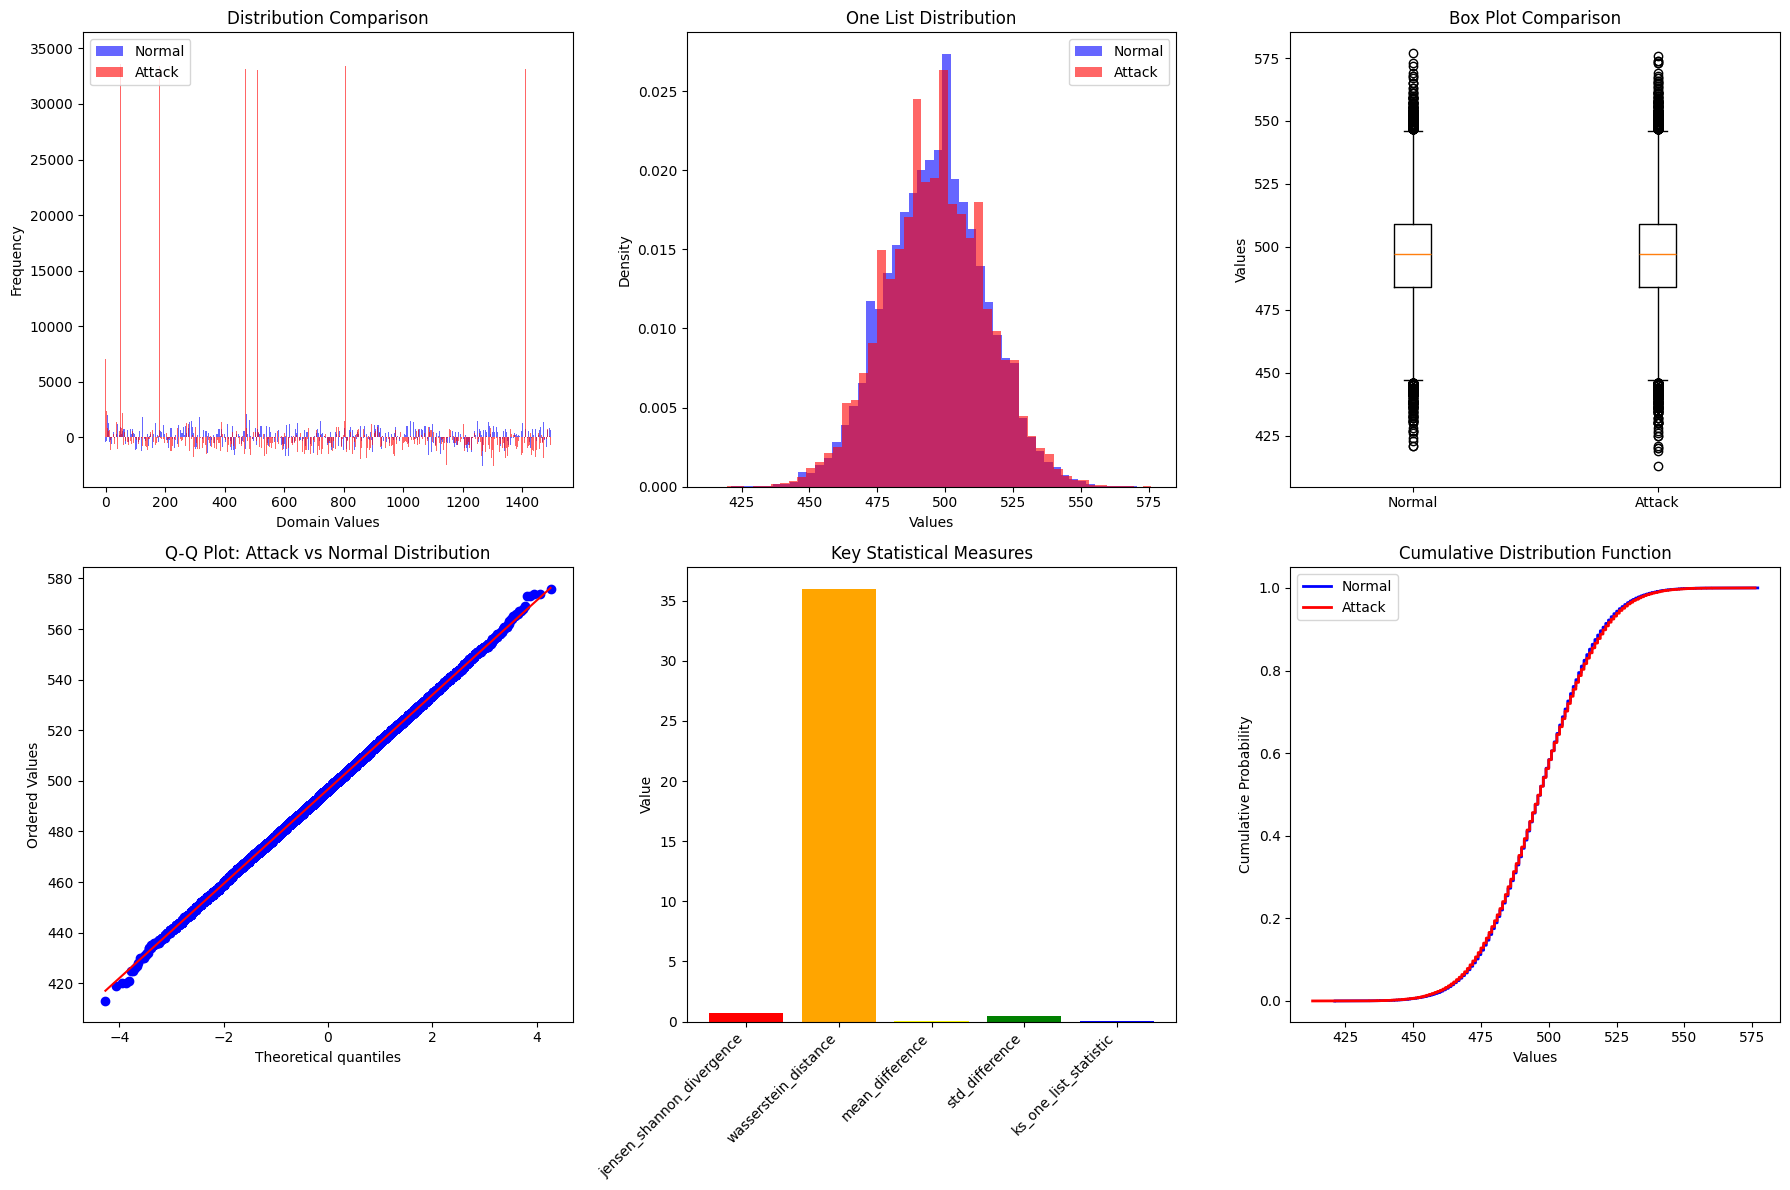

In [64]:
plot_comparison_analysis(
    ESTIMATE_DIST_Nattack,
    ideal_ESTIMATE_DIST,
    one_list,
    ideal_one_list,
    differences
)

# WGAN

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm



In [ ]:
class Generator(nn.Module):
    """
    Generator that transforms attacked one_list to look like ideal one_list
    """
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, x):
        return self.model(x)


In [75]:
class Discriminator(nn.Module):
    """
    Discriminator (Critic) that distinguishes between real ideal data and generated data
    """
    def __init__(self, input_dim=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
            # No sigmoid for WGAN (uses Wasserstein loss)
        )

    def forward(self, x):
        return self.model(x)

In [76]:
class AttackDetector(nn.Module):
    """
    Simple classifier to detect attacked vs non-attacked data
    """
    def __init__(self, input_dim=1, hidden_dim=32):
        super(AttackDetector, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [78]:
class WGAN:
    def __init__(self, generator, discriminator, device='cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device

        # WGAN optimizers (RMSprop is recommended)
        self.g_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
        self.d_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)

        # For weight clipping in WGAN
        self.clip_value = 0.01

    def train_step(self, attacked_data, ideal_data, n_critic=5):
        batch_size = attacked_data.size(0)

        # Train Discriminator (Critic)
        d_losses = []
        for _ in range(n_critic):
            self.d_optimizer.zero_grad()

            # Real data (ideal)
            real_validity = self.discriminator(ideal_data)

            # Fake data (generated from attacked)
            fake_data = self.generator(attacked_data)
            fake_validity = self.discriminator(fake_data.detach())

            # WGAN loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
            d_loss.backward()
            self.d_optimizer.step()

            # Clip weights
            for p in self.discriminator.parameters():
                p.data.clamp_(-self.clip_value, self.clip_value)

            d_losses.append(d_loss.item())

        # Train Generator
        self.g_optimizer.zero_grad()
        fake_data = self.generator(attacked_data)
        fake_validity = self.discriminator(fake_data)
        g_loss = -torch.mean(fake_validity)
        g_loss.backward()
        self.g_optimizer.step()

        return np.mean(d_losses), g_loss.item()

In [79]:
def prepare_data(attacked_one_list, ideal_one_list, no_attack_one_list):
    """
    Prepare data for training
    """
    # Normalize data (optional but often helpful)
    attacked_data = torch.FloatTensor(attacked_one_list).unsqueeze(1)
    ideal_data = torch.FloatTensor(ideal_one_list).unsqueeze(1)
    no_attack_data = torch.FloatTensor(no_attack_one_list).unsqueeze(1)

    # For classification: 1 = attacked, 0 = not attacked
    attack_labels = torch.ones(len(attacked_one_list))
    no_attack_labels = torch.zeros(len(no_attack_one_list))

    return attacked_data, ideal_data, no_attack_data, attack_labels, no_attack_labels

In [80]:
def train_wgan(attacked_data, ideal_data, epochs=1000, batch_size=64, device='cpu'):
    """
    Train WGAN model
    """
    # Initialize models
    generator = Generator()
    discriminator = Discriminator()
    wgan = WGAN(generator, discriminator, device)

    # Create data loaders
    min_len = min(len(attacked_data), len(ideal_data))
    attacked_subset = attacked_data[:min_len]
    ideal_subset = ideal_data[:min_len]

    dataset = TensorDataset(attacked_subset, ideal_subset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    d_losses, g_losses = [], []

    for epoch in tqdm(range(epochs)):
        epoch_d_losses, epoch_g_losses = [], []

        for attacked_batch, ideal_batch in dataloader:
            attacked_batch = attacked_batch.to(device)
            ideal_batch = ideal_batch.to(device)

            d_loss, g_loss = wgan.train_step(attacked_batch, ideal_batch)
            epoch_d_losses.append(d_loss)
            epoch_g_losses.append(g_loss)

        d_losses.append(np.mean(epoch_d_losses))
        g_losses.append(np.mean(epoch_g_losses))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: D_loss = {d_losses[-1]:.4f}, G_loss = {g_losses[-1]:.4f}")

    return wgan, d_losses, g_losses

In [81]:
def train_attack_detector(attacked_data, no_attack_data, epochs=500, batch_size=64, device='cpu'):
    """
    Train a simple classifier to detect attacks
    """
    detector = AttackDetector().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(detector.parameters(), lr=0.001)

    # Prepare labels
    attack_labels = torch.ones(len(attacked_data), 1)
    no_attack_labels = torch.zeros(len(no_attack_data), 1)

    # Combine data
    all_data = torch.cat([attacked_data, no_attack_data])
    all_labels = torch.cat([attack_labels, no_attack_labels])

    # Create dataset
    dataset = TensorDataset(all_data, all_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    for epoch in tqdm(range(epochs)):
        epoch_losses = []
        for data_batch, label_batch in dataloader:
            data_batch = data_batch.to(device)
            label_batch = label_batch.to(device)

            optimizer.zero_grad()
            outputs = detector(data_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(np.mean(epoch_losses))

        if epoch % 100 == 0:
            print(f"Detector Epoch {epoch}: Loss = {losses[-1]:.4f}")

    return detector, losses

In [82]:
def evaluate_models(wgan, detector, attacked_data, ideal_data, no_attack_data):
    """
    Evaluate both WGAN and attack detector
    """
    wgan.generator.eval()
    wgan.discriminator.eval()
    detector.eval()

    with torch.no_grad():
        # Generate transformed data
        generated_data = wgan.generator(attacked_data)

        # Test attack detection
        attack_pred = detector(attacked_data)
        no_attack_pred = detector(no_attack_data)

        # Calculate accuracy
        attack_acc = (attack_pred > 0.5).float().mean()
        no_attack_acc = (no_attack_pred <= 0.5).float().mean()
        overall_acc = (attack_acc + no_attack_acc) / 2

        print(f"Attack Detection Accuracy: {attack_acc:.3f}")
        print(f"No-Attack Detection Accuracy: {no_attack_acc:.3f}")
        print(f"Overall Accuracy: {overall_acc:.3f}")

        # Wasserstein distance approximation
        real_scores = wgan.discriminator(ideal_data).mean()
        fake_scores = wgan.discriminator(generated_data).mean()
        wasserstein_dist = abs(real_scores - fake_scores)

        print(f"Approximate Wasserstein Distance: {wasserstein_dist:.4f}")

        return {
            'generated_data': generated_data,
            'attack_predictions': attack_pred,
            'no_attack_predictions': no_attack_pred,
            'wasserstein_distance': wasserstein_dist,
            'overall_accuracy': overall_acc
        }

In [83]:
def plot_results(attacked_data, ideal_data, generated_data, d_losses, g_losses):
    """
    Plot training results and data distributions
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot original distributions
    axes[0, 0].hist(attacked_data.numpy().flatten(), alpha=0.7, label='Attacked', bins=30)
    axes[0, 0].hist(ideal_data.numpy().flatten(), alpha=0.7, label='Ideal', bins=30)
    axes[0, 0].set_title('Original Distributions')
    axes[0, 0].legend()

    # Plot generated vs ideal
    axes[0, 1].hist(generated_data.numpy().flatten(), alpha=0.7, label='Generated', bins=30)
    axes[0, 1].hist(ideal_data.numpy().flatten(), alpha=0.7, label='Ideal', bins=30)
    axes[0, 1].set_title('Generated vs Ideal')
    axes[0, 1].legend()

    # Plot WGAN losses
    axes[1, 0].plot(d_losses, label='Discriminator Loss')
    axes[1, 0].plot(g_losses, label='Generator Loss')
    axes[1, 0].set_title('WGAN Training Losses')
    axes[1, 0].legend()

    # Plot scatter: original vs generated
    axes[1, 1].scatter(attacked_data.numpy().flatten(), generated_data.numpy().flatten(), alpha=0.5)
    axes[1, 1].plot([attacked_data.min(), attacked_data.max()],
                   [attacked_data.min(), attacked_data.max()], 'r--', label='y=x')
    axes[1, 1].set_xlabel('Attacked Data')
    axes[1, 1].set_ylabel('Generated Data')
    axes[1, 1].set_title('Attacked vs Generated')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [86]:
print("Preparing data...")
attacked_data, ideal_data, no_attack_data, attack_labels, no_attack_labels = prepare_data(
    one_list, ideal_one_list, no_attack_one_list
)


Preparing data...


In [87]:
print(f"Data shapes:")
print(f"  Attacked: {attacked_data.shape}")
print(f"  Ideal: {ideal_data.shape}")
print(f"  No Attack: {no_attack_data.shape}")

Data shapes:
  Attacked: torch.Size([70000, 1])
  Ideal: torch.Size([70000, 1])
  No Attack: torch.Size([70000, 1])


In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
print("Training WGAN...")
wgan, d_losses, g_losses = train_wgan(attacked_data, ideal_data, epochs=500, device=device)

Training WGAN...


  0%|          | 1/500 [00:11<1:37:05, 11.67s/it]

Epoch 0: D_loss = -0.7260, G_loss = -0.0083


  1%|▏         | 7/500 [01:26<1:49:57, 13.38s/it]

In [ ]:
print("Training attack detector...")
detector, detector_losses = train_attack_detector(attacked_data, no_attack_data, epochs=300, device=device)

In [ ]:
print("Evaluating models...")
results = evaluate_models(wgan, detector, attacked_data, ideal_data, no_attack_data)

In [ ]:
print("Plotting results...")
plot_results(attacked_data, ideal_data, results['generated_data'], d_losses, g_losses)